<h1><center>Stock Picking - S&P 500</center></h1>
<h2><center>By: Wiebke Plückhahn</center></h2>
<h3><center>Date: 12/01/2022</center></h3>
This is more of a personal project as I was interested in what stocks to buy. Feel free to run the code for real-time recommendations. But bear in mind that this notebook uses the yahoo finance API which is known for long runtimes.

<h2>Prerequistes: Data Acquisition</h2>

In [1]:
#Environment setup
%pip install yfinance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import yfinance as yf
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings("ignore")
checkpoint1 = np.datetime64('now')

Note: you may need to restart the kernel to use updated packages.


First, the tickers of all S&P 500 stocks are needed. I collect them by webscraping the correspronding wikipedia page with BeautifulSoup.

In [2]:
# get the response in the form of html
wikiurl="https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)
print(response.status_code, "--> 200 means good to go")
checkpoint2 = np.datetime64('now')
print('Done. This section took', checkpoint2 - checkpoint1, "to run. Current time:", checkpoint2)

200 --> 200 means good to go
Done. This section took 0 seconds to run. Current time: 2022-12-01T18:46:04


In [3]:
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')
sp500table=soup.find('table',{'class':"wikitable"})
df=pd.read_html(str(sp500table))
# convert list to dataframe
df=pd.DataFrame(df[0])
df.drop(columns=['SEC filings', 'GICS Sector', 'GICS Sub-Industry', 'Headquarters Location', 'CIK', 'Founded'], inplace=True)
df['Symbol'] = df.Symbol.str.replace('.', '-')
checkpoint3 = np.datetime64('now')
print('Done. This section took', checkpoint3 - checkpoint2, "to run. Current time:", checkpoint3)
df.head(2)

Done. This section took 1 seconds to run. Current time: 2022-12-01T18:46:05


,Symbol,Security,Date first added
0,MMM,3M,1976-08-09
1,AOS,A. O. Smith,2017-07-26


Next up, the yfinance API comes into play. Yahoo provides detailed information about every stock on a daily basis accessible by the ticker.
In the following chunk, the daily closings of all S&P 500 shares are processed into the data frame.

In [4]:
sp500stocks = df['Symbol']
sp500l = sp500stocks.tolist()
today = yf.download(sp500l, actions = False, period='1d')
today.drop(columns=["Open", "High", "Low", "Adj Close", "Volume"], inplace=True)
today=today.droplevel(0, axis=1)
today=today.transpose()
today.reset_index(inplace=True)
today.columns = ['Symbol', 'Closing Today']
df = pd.merge(df, today, how='left', on='Symbol')
checkpoint4 = np.datetime64('now')
print('Done. This section took', checkpoint4 - checkpoint3, "to run. Current time:", checkpoint4)
df.head(1)

[*********************100%***********************]  503 of 503 completed
Done. This section took 16 seconds to run. Current time: 2022-12-01T18:46:21


,Symbol,Security,Date first added,Closing Today
0,MMM,3M,1976-08-09,125.830101


To put things into perspective and evaluate whether shares are considerably cheap or expensive, I next import the 10 year high of all stocks.

In [5]:
data = yf.download(sp500l, actions = False, period="10y")
data.drop(columns=["Open", "Close", "Low", "Adj Close", "Volume"], inplace=True)
data=data.droplevel(0, axis=1)
data=data.transpose()
data["10 Year High"] = data.max(axis=1)
data.reset_index(inplace=True)
data=data.rename(columns={'index': 'Symbol'})
datatemp = data[['Symbol', "10 Year High"]]
df = pd.merge(df, datatemp, how='left', on='Symbol')
checkpoint5 = np.datetime64('now')
print('Done. This section took', checkpoint5 - checkpoint4, "to run. Current time:", checkpoint5)
df.head(1)

[*********************100%***********************]  503 of 503 completed
Done. This section took 41 seconds to run. Current time: 2022-12-01T18:47:02


,Symbol,Security,Date first added,Closing Today,10 Year High
0,MMM,3M,1976-08-09,125.830101,259.769989


Now, the Price-to-Earning-Ratio (PER), Dividend Rate per stock, Earnings Growth, 52 Week Beta and Mean and Low Target Prices by different brokerages are imported.
Thereafter. different parameters are computed. Namely, ratios of the last closing price to mean and low target prices as well as to the 10 year high are calculated.

In [6]:
popped_element = sp500l.pop(0)
keys=['forwardPE', 'dividendYield', 'revenuePerShare', 'earningsGrowth', 'beta', 'targetLowPrice', 'targetMeanPrice']

# first stock
ticker = yf.Ticker(popped_element)
tempdict = {attr: ticker.info[attr]for attr in keys}
PER = pd.DataFrame([tempdict])

# append all
for stock in sp500l:
    ticker = yf.Ticker(stock)
    tempdict = {}
    for attr in keys:
        if attr in ticker.info:
            tempdict[attr] = ticker.info[attr]
        else:
            tempdict[attr] = 0
    PERtemp = pd.DataFrame([tempdict])
    PER = pd.concat([PER, PERtemp],axis=0)
sp500l.insert(0, popped_element)
PER['Symbol']=sp500l
PER.reset_index(inplace=True)
PER.drop(columns=['index'], inplace=True)
PER.columns = ['PER', 'Dividend Rate', 'Revenue Per Share', 'Earnings Growth', '52W Beta', \
               'Target Low Price', 'Target Mean Price', 'Symbol']
df = pd.merge(df, PER, how='left', on='Symbol')
#some values are smaller than zero -> most likely error data, replace with mean
df['PER'] = df['PER'].mask(df['PER'] < 0, np.nan)  
df['PER'].fillna(df['PER'].mean())
df['Target Low Price'] = pd.to_numeric(df['Target Low Price'],errors = 'coerce')
df['Target Low Price'] = df['Target Low Price'].replace(0, np.nan)
df['Target Mean Price'] = df['Target Mean Price'].replace(0, np.nan)
df['Low Target Rate'] = df['Closing Today']/df['Target Low Price']
df['Mean Target Rate'] = df['Closing Today']/df['Target Mean Price']
df['Price Ratio'] = df['Closing Today'] / df['10 Year High']
checkpoint6 = np.datetime64('now')
print('Done. This section took', checkpoint6 - checkpoint5, "to run. Current time:", checkpoint6)
df.head(1)

Done. This section took 2499 seconds to run. Current time: 2022-12-01T19:28:41


,Symbol,Security,Date first added,Closing Today,10 Year High,PER,Dividend Rate,Revenue Per Share,Earnings Growth,52W Beta,Target Low Price,Target Mean Price,Low Target Rate,Mean Target Rate,Price Ratio
0,MMM,3M,1976-08-09,125.830101,259.769989,11.885741,0.0503,61.062,NaN,NaN,110.0,131.13,1.14391,0.959583,0.48439


Following up, dividend per year for the past 5 years is going to be read in. As some companies pay dividends as late as 31st December, data from 2021 is used to calculate the Payout Ratio (yearly dividend per revenue per share).

In [7]:
popped_element = sp500l.pop(0)

#DF Structure
ticker = yf.Ticker(popped_element)
a = pd.DataFrame([ticker.dividends])
if a.empty == False:
    a = a.transpose()
    a.reset_index(inplace=True)
    a['Year'] = pd.DatetimeIndex(a['Date']).year
    b = a.pivot(columns='Year', values='Dividends').transpose().tail(6)
    b['Sum per Year'] = b.sum(axis=1)
    b.reset_index(inplace=True)
    b = b[['Year', 'Sum per Year']]
    b = b.set_index('Year').transpose()
    b.reset_index(inplace=True)
    b.drop(columns=['index'], inplace=True)
    if not 2016 in b.columns:
        b[2016]=0
    if not 2017 in b.columns:
        b[2017]=0
    if not 2018 in b.columns:
        b[2018]=0
    if not 2019 in b.columns:
        b[2019]=0
    if not 2020 in b.columns:
        b[2020]=0
    if not 2021 in b.columns:
        b[2021]=0
    if not 2022 in b.columns:
        b[2022]=0
    b = b[[2016, 2017, 2018, 2019, 2020, 2021, 2022]]
    b.columns = ["Dividend 2016", "Dividend 2017", "Dividend 2018", "Dividend 2019", "Dividend 2020", "Dividend 2021", "Dividend 2022"]
else:
    b=pd.DataFrame({'Dividend 2016': [0],
                'Dividend 2017': [0],  
                'Dividend 2018': [0],
                'Dividend 2019': [0],
                'Dividend 2020': [0],
                'Dividend 2021': [0],
                'Dividend 2022': [0]},
                index = [0])
    
#append all
for stock in sp500l:
    ticker = yf.Ticker(stock)
    c = pd.DataFrame([ticker.dividends])
    if c.empty == False:
        c = c.transpose()
        c.reset_index(inplace=True)
        c['Year'] = pd.DatetimeIndex(c['Date']).year
        d = c.pivot(columns='Year', values='Dividends').transpose().tail(6)
        d['Sum per Year'] = d.sum(axis=1)
        d.reset_index(inplace=True)
        d = d[['Year', 'Sum per Year']]
        d = d.set_index('Year').transpose()
        d.reset_index(inplace=True)
        d.drop(columns=['index'], inplace=True)
        if not 2016 in d.columns:
            d[2016]=0
        if not 2017 in d.columns:
            d[2017]=0
        if not 2018 in d.columns:
            d[2018]=0
        if not 2019 in d.columns:
            d[2019]=0
        if not 2020 in d.columns:
            d[2020]=0
        if not 2021 in d.columns:
            d[2021]=0
        if not 2022 in d.columns:
            d[2022]=0
        d = d[[2016, 2017, 2018, 2019, 2020, 2021, 2022]]
        d.columns = ["Dividend 2016", "Dividend 2017", "Dividend 2018", "Dividend 2019", "Dividend 2020", "Dividend 2021", "Dividend 2022"]
    else:
        d=pd.DataFrame({'Dividend 2016': [0],
                'Dividend 2017': [0],
                'Dividend 2018': [0],
                'Dividend 2019': [0],
                'Dividend 2020': [0],
                'Dividend 2021': [0],
                'Dividend 2022': [0]},
                index = [0])
    b = pd.concat([b, d],axis=0)
sp500l.insert(0, popped_element)
b['Symbol']=sp500l
b.reset_index(inplace=True)
b.drop(columns=['index'], inplace=True)
df = pd.merge(df, b, how='left', on='Symbol')
df['Payout Ratio']=df['Dividend 2021']/df['Revenue Per Share']
checkpoint7 = np.datetime64('now')
print('Done. This section took', checkpoint7 - checkpoint6, "to run. Current time:", checkpoint7)
df.head(1)

Done. This section took 949 seconds to run. Current time: 2022-12-01T19:44:30


,Symbol,Security,Date first added,Closing Today,10 Year High,PER,Dividend Rate,Revenue Per Share,Earnings Growth,52W Beta,...,Mean Target Rate,Price Ratio,Dividend 2016,Dividend 2017,Dividend 2018,Dividend 2019,Dividend 2020,Dividend 2021,Dividend 2022,Payout Ratio
0,MMM,3M,1976-08-09,125.830101,259.769989,11.885741,0.0503,61.062,NaN,NaN,...,0.959583,0.48439,0.0,4.7,5.44,5.76,5.88,5.92,1.49,0.096951


Finally, the last chunk of data is going to be scraped. Here, the Debt to Earnings (DE) Ratio is computed after importing total liabilities and total stockholder equity per stock.

In [8]:
popped_element = sp500l.pop(0)

# first stock
ticker = yf.Ticker(popped_element)
dftemp = ticker.balance_sheet.transpose()
dftemp.reset_index(inplace=True)
dftemp = dftemp[['Total Liab', 'Total Stockholder Equity']].head(1)
# append all
for stock in sp500l:
    ticker = yf.Ticker(stock)
    dftemp2 = ticker.balance_sheet.transpose()
    dftemp2.reset_index(inplace=True)
    if not 'Total Stockholder Equity' in dftemp2.columns:
        dftemp2 = pd.DataFrame({'Total Liab': [0],
            'Total Stockholder Equity': [0]
        }, index = [0])
    else: 
        dftemp2 = dftemp2[['Total Liab', 'Total Stockholder Equity']].head(1)
    dftemp = pd.concat([dftemp, dftemp2])
sp500l.insert(0, popped_element)
dftemp['Symbol']=sp500l
dftemp.reset_index(inplace=True)
dftemp.drop(columns=['index'], inplace=True)
df = pd.merge(df, dftemp, how='left', on='Symbol')
df['DE Ratio']=df['Total Liab']/df['Total Stockholder Equity']
#some values are smaller than zero -> most likely error data, replace with mean
df['DE Ratio'] = df['DE Ratio'].mask(df['DE Ratio'] < 0, np.nan)  
df['DE Ratio'].fillna(df['DE Ratio'].mean())
checkpoint8 = np.datetime64('now')
print('Done. This section took', checkpoint8 - checkpoint7, "to run. Current time:", checkpoint8)
df.head(1)

Done. This section took 4491 seconds to run. Current time: 2022-12-01T20:59:21


,Symbol,Security,Date first added,Closing Today,10 Year High,PER,Dividend Rate,Revenue Per Share,Earnings Growth,52W Beta,...,Dividend 2017,Dividend 2018,Dividend 2019,Dividend 2020,Dividend 2021,Dividend 2022,Payout Ratio,Total Liab,Total Stockholder Equity,DE Ratio
0,MMM,3M,1976-08-09,125.830101,259.769989,11.885741,0.0503,61.062,NaN,NaN,...,4.7,5.44,5.76,5.88,5.92,1.49,0.096951,3.195500e+10,1.504600e+10,2.12382


<h3>Divdiend stock data wrangling</h3>

I classify all shares into **growth** and **dividend** stocks.
In this section, data of dividend stocks will be prepared. First, I'm interested in the average dividend growth during the past 5 years. This will be computed for all shares as it might be interesting for grwoth stocks, too.

In [9]:
df['Div Growth 20-21'] = df['Dividend 2021'] / df['Dividend 2020']
df['Div Growth 19-20'] = df['Dividend 2020'] / df['Dividend 2019']
df['Div Growth 18-19'] = df['Dividend 2019'] / df['Dividend 2018']
df['Div Growth 17-18'] = df['Dividend 2018'] / df['Dividend 2017']
df['Avg Div Growth 5y'] = df[['Div Growth 20-21', 'Div Growth 19-20', 'Div Growth 18-19', \
                              'Div Growth 17-18']].mean(axis=1)
checkpoint9 = np.datetime64('now')
print('Done. This section took', checkpoint9 - checkpoint8, "to run. Current time:", checkpoint9)
df.head(1)

Done. This section took 0 seconds to run. Current time: 2022-12-01T20:59:21


,Symbol,Security,Date first added,Closing Today,10 Year High,PER,Dividend Rate,Revenue Per Share,Earnings Growth,52W Beta,...,Dividend 2022,Payout Ratio,Total Liab,Total Stockholder Equity,DE Ratio,Div Growth 20-21,Div Growth 19-20,Div Growth 18-19,Div Growth 17-18,Avg Div Growth 5y
0,MMM,3M,1976-08-09,125.830101,259.769989,11.885741,0.0503,61.062,NaN,NaN,...,1.49,0.096951,3.195500e+10,1.504600e+10,2.12382,1.006803,1.020833,1.058824,1.157447,1.060977


Now a dataframe is created which contains only data of dividend stocks. Criteria are:
- that at least **2.5% dividends per share** are currently paid, 
- that the **payout rate is below 50%** in order to invest in potentially healthy companies that not only distribute their profits to stakeholders but can also reinvest them in their own company,
- that dividends **have been paid** without interruption in the **last 5 years** in order to take established companies into account, since young companies that have only recently started paying dividends run the risk of having to stop payments again soon,
- and also that there have been **no major slumps in dividend growth** in the last 5 years. 

These are all indicators of healthy, established and stable companies that are particularly suitable for investing in dividend stocks.

In [11]:
Divstocks = df
#min. 2.5% dividend
Divstocks= Divstocks[Divstocks['Dividend Rate'] >= 0.025]
#less than 50% payout rate
Divstocks = Divstocks[Divstocks['Payout Ratio'] < 0.5]
#paying dividends in past 5 years
Divstocks = Divstocks[Divstocks['Dividend 2021'] > 0]
Divstocks = Divstocks[Divstocks['Dividend 2020'] > 0]
Divstocks = Divstocks[Divstocks['Dividend 2019'] > 0]
Divstocks = Divstocks[Divstocks['Dividend 2018'] > 0]
Divstocks = Divstocks[Divstocks['Dividend 2017'] > 0]
#no slumps in dividends
Divstocks = Divstocks[Divstocks['Div Growth 20-21'] >=1]
Divstocks = Divstocks[Divstocks['Div Growth 19-20'] >=1]
Divstocks = Divstocks[Divstocks['Div Growth 18-19'] >=1]
Divstocks = Divstocks[Divstocks['Div Growth 17-18'] >=1]
checkpoint10 = np.datetime64('now')
print('Done. This section took', checkpoint10 - checkpoint9, "to run. Current time:", checkpoint10)
Divstocks.info()

Done. This section took 758 seconds to run. Current time: 2022-12-01T21:11:59
<class 'pandas.core.frame.DataFrame'>
Int64Index: 116 entries, 0 to 501
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Symbol                    116 non-null    object 
 1   Security                  116 non-null    object 
 2   Date first added          99 non-null     object 
 3   Closing Today             116 non-null    float64
 4   10 Year High              116 non-null    float64
 5   PER                       116 non-null    float64
 6   Dividend Rate             116 non-null    float64
 7   Revenue Per Share         116 non-null    float64
 8   Earnings Growth           102 non-null    float64
 9   52W Beta                  107 non-null    float64
 10  Target Low Price          114 non-null    float64
 11  Target Mean Price         114 non-null    float64
 12  Low Target Rate           114 non-null    

Now the heart of the project is calculated: The **Reccomendation Score**.  
In general, the following dividend stocks are recommended:
- stocks that are relatively cheap and have a price to earnings ratio of less than 30
- stocks that pay at least 4% dividend per year
- stocks that cost at least 10% less than all time high
- stocks that are not overpriced by the analysis of brokerages

The score is a weighted compound of:
- the **price ratio** (closing today in relation to 10 year high)
- the **price to earning ratio**
- the **dividend rate** (weighed double)
- the **52 week beta** (weighed half)
- the **underevaluation by brokerages** with rewarding highly underpriced stocks
- the **debt to earnings ratio**
- the **average dividend growth** during past 5 years


All shares are individully assessed in relation to the other shares.

In [12]:
DivRecom = Divstocks[['Symbol', 'Security', 'PER', 'Dividend Rate', 'Price Ratio', 'Mean Target Rate', 'Low Target Rate', '52W Beta', 'DE Ratio', 'Avg Div Growth 5y', 'Closing Today']]
DivRecom = DivRecom[~DivRecom.isnull().any(axis=1)]
#PER < 30
DivRecom = DivRecom[DivRecom['PER'] <= 30]
#min. 4% dividend rate
DivRecom = DivRecom[DivRecom['Dividend Rate'] >= 0.04]
#ratio to all time high
DivRecom = DivRecom[DivRecom['Price Ratio'] <= 0.9]
#average evaluation by brokerages
DivRecom = DivRecom[DivRecom['Mean Target Rate'] <= 1]
#calculation of score
DivRecom['Recommendation Score Div'] = ((1 - DivRecom['Price Ratio']/DivRecom['Price Ratio'].max()) \
    + (1 - DivRecom['PER']/DivRecom['PER'].max()) \
    + (2 * DivRecom['Dividend Rate']/DivRecom['Dividend Rate'].max()) \
    + (0.5 * (1 - DivRecom['52W Beta']/DivRecom['52W Beta'].max())) \
    + (0.5 * (1 - DivRecom['Low Target Rate'])) \
    + (0.5 * (1 - DivRecom['Mean Target Rate'])) \
    + (1 - DivRecom['DE Ratio']/DivRecom['DE Ratio'].max()) \
    + (DivRecom['Avg Div Growth 5y']/DivRecom['Avg Div Growth 5y'].max())) /6.5
checkpoint11 = np.datetime64('now')
print('Done. This section took', checkpoint11 - checkpoint10, "to run. Current time:", checkpoint11)
DivRecom.sort_values('Recommendation Score Div', ascending = False)

Done. This section took 14 seconds to run. Current time: 2022-12-01T21:12:13


,Symbol,Security,PER,Dividend Rate,Price Ratio,Mean Target Rate,Low Target Rate,52W Beta,DE Ratio,Avg Div Growth 5y,Closing Today,Recommendation Score Div
375,PXD,Pioneer Natural Resources,17.259928,0.0767,0.829820,0.848168,1.093014,1.479734,0.611902,3.171970,239.369995,0.691443
470,VZ,Verizon,7.351064,0.0721,0.611299,0.822556,1.226935,0.373249,3.464922,1.020853,38.035000,0.650580
472,VFC,VF Corporation,11.272575,0.0709,0.337556,0.993833,1.301538,0.973992,2.779282,1.050744,33.840000,0.646392
276,KMI,Kinder Morgan,20.777174,0.0626,0.427868,0.962274,1.062778,0.916728,1.248905,1.221674,19.129999,0.598700
52,T,AT&T,6.032492,0.0616,0.577208,0.949588,2.126022,0.653647,2.211042,1.077504,19.134199,0.555784
146,DVN,Devon Energy,26.160307,0.0810,0.850986,0.850775,1.143583,2.434045,1.255236,1.589881,68.614998,0.536060
163,EMN,Eastman Chemical Company,9.531457,0.0401,0.663294,0.895488,1.109487,1.492262,1.705996,1.078895,86.540001,0.502494
454,TFC,Truist,9.537715,0.0471,0.669471,0.890260,1.099048,1.093220,7.539698,1.105053,46.160000,0.464412
160,DUK,Duke Energy,18.372477,0.0442,0.862030,0.956688,1.066808,0.411569,2.502451,1.028196,100.279999,0.454172
492,WMB,Williams Companies,28.357723,0.0529,0.568019,0.930975,1.162167,1.226971,2.942659,1.082153,34.865002,0.451078


<h3>Growth stock data wrangling</h3>

In the following, a dataframe is created which contains only data of growth stocks with a potential to develop well. Criteria are:
- that at least **100% earnings growth** are reported
OR
- the **evaluation above average by brokerages**

In [13]:
Growthstocks = df
#min. 100% earnings growth
Growthstockstemp = Growthstocks[Growthstocks['Earnings Growth'] >= 1]
#OR evaluation above average
Growthstocks = Growthstocks[Growthstocks['Low Target Rate'] < 1]
growthstocklist1 = Growthstockstemp['Symbol'].tolist()
growthstocklist2 = Growthstocks['Symbol'].tolist()
new=set(growthstocklist2)-set(growthstocklist1)
growthstocklist=growthstocklist1 + list(new)
Growthstocks = df[df['Symbol'].isin(growthstocklist)]
#exclude shares with negative earnings growth
Growthstocks = Growthstocks[Growthstocks['Earnings Growth'] >= 0]
checkpoint12 = np.datetime64('now')
print('Done. This section took', checkpoint12 - checkpoint11, "to run. Current time:", checkpoint12)

Done. This section took 0 seconds to run. Current time: 2022-12-01T21:12:13


Once again, a **Reccomendation Score** is computed.
In general, the following growth stocks are recommended:

- stocks that are relatively cheap and have a price to earnings ratio of less than 35
- stocks that cost at least 10% less than all time high

The score is a weighted compound of:

- the **price ratio** (closing today in relation to 10 year high)
- the **price to earning ratio**
- the **dividend rate** (weighed half)
- the **52 week beta** (weighed half)
- the **underevaluation by brokerages** with rewarding highly underpriced stocks
- the **earnings growth** (weighed 1.5 times)

All shares are individully assessed in relation to the other shares.

In [14]:
GrwRecom = Growthstocks[['Symbol', 'Security', 'PER', 'Dividend Rate', 'Price Ratio', 'Mean Target Rate', 'Low Target Rate', '52W Beta', 'DE Ratio', 'Earnings Growth', 'Closing Today']]
GrwRecom = GrwRecom[~GrwRecom.isnull().any(axis=1)]

#Applying criteria
GrwRecom = GrwRecom.loc[(GrwRecom['PER'] <= 30) & (GrwRecom['Price Ratio'] <= 0.9)]

#Score
GrwRecom['Recommendation Score Growth'] = ((1 - GrwRecom['Price Ratio']/GrwRecom['Price Ratio'].max()) \
                                           + (1 - GrwRecom['PER']/GrwRecom['PER'].max()) \
                                           + (0.5 * GrwRecom['Dividend Rate']/GrwRecom['Dividend Rate'].max()) \
                                           + (0.5 * (1 - GrwRecom['52W Beta']/GrwRecom['52W Beta'].max())) \
                                           + (0.5 * (1 - GrwRecom['Low Target Rate'])) \
                                           + (0.5 * (1 - GrwRecom['Mean Target Rate'])) \
                                           + (0.5 * (1 - GrwRecom['DE Ratio']/GrwRecom['DE Ratio'].max())) \
                                           + (1.5 * GrwRecom['Earnings Growth']/GrwRecom['Earnings Growth'].max())) /6
checkpoint13 = np.datetime64('now')
print('Done. This section took', checkpoint13 - checkpoint12, "to run. Current time:", checkpoint13)
GrwRecom.sort_values('Recommendation Score Growth', ascending = False)

Done. This section took 0 seconds to run. Current time: 2022-12-01T21:12:13


,Symbol,Security,PER,Dividend Rate,Price Ratio,Mean Target Rate,Low Target Rate,52W Beta,DE Ratio,Earnings Growth,Closing Today,Recommendation Score Growth
68,TECH,Bio-Techne,12.139045,0.0042,0.636131,0.185896,0.240250,1.275239,0.348927,3.105,86.489998,0.486613
334,NWL,Newell Brands,6.734210,0.0584,0.232913,0.644140,0.861000,0.864038,2.465901,0.065,12.915000,0.475630
373,PSX,Phillips 66,15.871870,0.0379,0.865451,0.956154,1.117604,1.358511,1.771731,8.893,107.290001,0.470624
379,PPL,PPL Corporation,11.137405,0.0350,0.727861,1.014563,1.219167,0.795873,1.420972,5.480,29.260000,0.433454
375,PXD,Pioneer Natural Resources,17.259928,0.0767,0.829820,0.848168,1.093014,1.479734,0.611902,5.055,239.369995,0.414739
256,IFF,International Flavors & Fragrances,16.110773,0.0338,0.676964,0.649760,0.702817,1.068533,0.874490,2.886,106.554100,0.406429
148,FANG,Diamondback Energy,14.136585,0.0796,0.859544,0.830778,1.015524,1.997789,0.798561,3.665,145.220001,0.380810
146,DVN,Devon Energy,26.160307,0.0810,0.850986,0.850775,1.143583,2.434045,1.255236,6.771,68.614998,0.369527
209,FOX,Fox Corporation (Class B),12.819149,0.0179,0.714286,0.584466,0.584466,0.890279,0.936767,0.257,30.100000,0.349892
309,MDT,Medtronic,13.815246,0.0319,0.582640,0.750687,0.931471,0.768238,0.728036,0.248,79.175003,0.345186


In [15]:
#Combining all data frames
#Dividend stocks
Divstocks = pd.merge(Divstocks, DivRecom[['Symbol', 'Recommendation Score Div']], how='left', on='Symbol')
Divstocks['Dividend Stock'] = 1
#Growth stocks
Growthstocks = pd.merge(Growthstocks, GrwRecom[['Symbol', 'Recommendation Score Growth']], how='left', on='Symbol')
Growthstocks['Growthstock'] = 1
#Gesamt-Datensatz
df = pd.merge(df, Divstocks[['Symbol', 'Dividend Stock', 'Recommendation Score Div']], how='left', on='Symbol')
df = pd.merge(df, Growthstocks[['Symbol', 'Growthstock', 'Recommendation Score Growth']], how='left', on='Symbol')
df['Recommendation Score'] = df[['Recommendation Score Div', 'Recommendation Score Growth']].max(axis=1)
checkpoint14 = np.datetime64('now')
print('Done. This section took', checkpoint14 - checkpoint13, "to run. Current time:", checkpoint14)
df.sort_values('Recommendation Score', ascending=False).head(15)

Done. This section took 0 seconds to run. Current time: 2022-12-01T21:12:13


,Symbol,Security,Date first added,Closing Today,10 Year High,PER,Dividend Rate,Revenue Per Share,Earnings Growth,52W Beta,...,Div Growth 20-21,Div Growth 19-20,Div Growth 18-19,Div Growth 17-18,Avg Div Growth 5y,Dividend Stock,Recommendation Score Div,Growthstock,Recommendation Score Growth,Recommendation Score
375,PXD,Pioneer Natural Resources,2008-09-24,239.369995,288.459991,17.259928,0.0767,97.490,5.055,1.479734,...,3.104545,1.833333,3.750000,4.000000,3.171970,1.0,0.691443,1.0,0.414739,0.691443
470,VZ,Verizon,1983-11-30,38.035000,62.220001,7.351064,0.0721,32.352,-0.246,0.373249,...,1.020623,1.020215,1.021492,1.021084,1.020853,1.0,0.650580,NaN,NaN,0.650580
472,VFC,VF Corporation,1979-06-30,33.840000,100.250000,11.272575,0.0709,30.365,NaN,0.973992,...,1.020725,1.015669,1.067746,1.098838,1.050744,1.0,0.646392,NaN,NaN,0.646392
276,KMI,Kinder Morgan,2012-05-25,19.129999,44.709999,20.777174,0.0626,8.413,0.172,0.916728,...,1.033719,1.092632,1.310345,1.450000,1.221674,1.0,0.598700,NaN,NaN,0.598700
52,T,AT&T,1983-11-30 (1957-03-04),19.134199,33.149548,6.032492,0.0616,21.664,-0.023,0.653647,...,1.250000,1.019608,1.020000,1.020408,1.077504,1.0,0.555784,NaN,NaN,0.555784
146,DVN,Devon Energy,2000-08-30,68.614998,80.629997,26.160307,0.0810,26.482,6.771,2.434045,...,2.250000,1.942857,1.166667,1.000000,1.589881,1.0,0.536060,1.0,0.369527,0.536060
163,EMN,Eastman Chemical Company,1994-01-01,86.540001,130.470001,9.531457,0.0401,83.713,NaN,1.492262,...,1.059925,1.059524,1.095652,1.100478,1.078895,1.0,0.502494,NaN,NaN,0.502494
68,TECH,Bio-Techne,2021-08-30,86.489998,135.962494,12.139045,0.0042,28.190,3.105,1.275239,...,0.500000,1.000000,1.000000,1.000000,0.875000,NaN,NaN,1.0,0.486613,0.486613
334,NWL,Newell Brands,1989-04-30,12.915000,55.450001,6.734210,0.0584,24.932,0.065,0.864038,...,0.500000,1.000000,1.000000,1.045455,0.886364,NaN,NaN,1.0,0.475630,0.475630
373,PSX,Phillips 66,2012-05-01,107.290001,123.970001,15.871870,0.0379,325.612,8.893,1.358511,...,1.005556,1.028571,1.129032,1.135531,1.074673,1.0,NaN,1.0,0.470624,0.470624


<h2>Visualization: Have an eye on these!</h2>

<h3>Section 2.1: Dividend stocks<h3>

<h4>Recommendation score champs</h4>

In [16]:
#generate df with top 3 recommendation scores
DivRecomTop3 = DivRecom.sort_values('Recommendation Score Div', ascending = False).head(3).reset_index()

#scrape market data of the past year
top3div = DivRecomTop3['Symbol'].to_list()
plotdata = yf.download(top3div, actions = False, period="1y")
plotdata.drop(columns=["Open", "High", "Low", "Adj Close", "Volume"], inplace=True)
plotdata = plotdata.droplevel(0, axis=1)
plotdata.reset_index(inplace=True)

#generate df for plotting
parameterplot = DivRecomTop3[['Symbol', 'Recommendation Score Div', 'PER', 'Dividend Rate', '52W Beta', 'Avg Div Growth 5y', 'DE Ratio']]
parameterplot['Recommendation Score Div'] = parameterplot['Recommendation Score Div']*1.75
parameterplot['PER'] = parameterplot['PER']/50
parameterplot['Dividend Rate'] = parameterplot['Dividend Rate']*10
parameterplot['Avg Div Growth 5y'] = parameterplot['Avg Div Growth 5y']/10
parameterplot['DE Ratio'] = parameterplot['DE Ratio']/10
parameterplot = parameterplot.transpose().reset_index().iloc[1: , :]

[*********************100%***********************]  3 of 3 completed


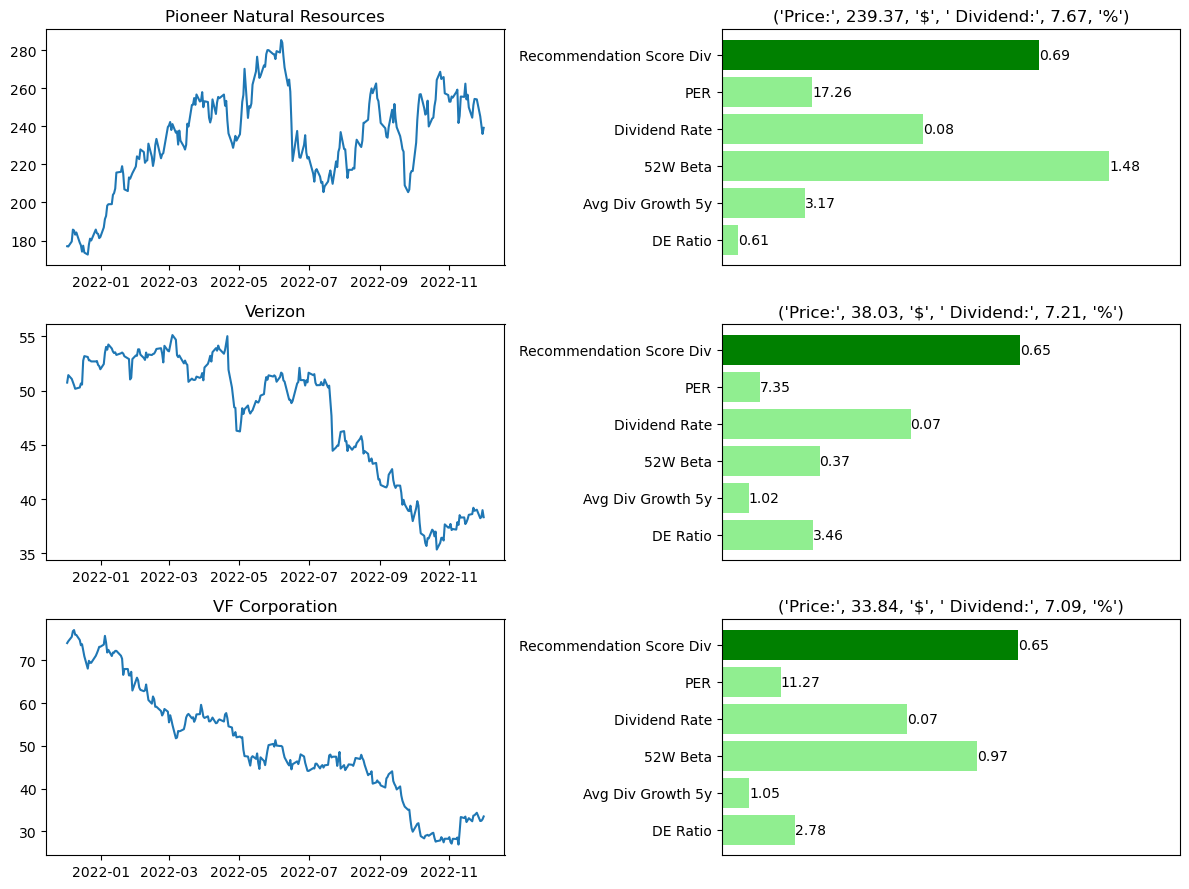

In [17]:
#build figure
fig=plt.figure()
fig.set_size_inches(12, 9)

ax=fig.add_subplot(321)
ax.set(title=DivRecomTop3.at[0, 'Security'])
ax.plot(plotdata['Date'], plotdata[DivRecomTop3.at[0, 'Symbol']])

ax=fig.add_subplot(322)
ax.set(title=("Price:", round(DivRecomTop3.at[0, 'Closing Today'], 2), "$", " Dividend:", round(DivRecomTop3.at[0, 'Dividend Rate']*100, 2), "%"))
hbars = ax.barh(parameterplot['index'], parameterplot[0], color=['green','lightgreen','lightgreen' ,'lightgreen' ,'lightgreen' ,'lightgreen'])
ax.tick_params(
    axis='x',         
    which='both',    
    bottom=False,    
    top=False,        
    labelbottom=False)
ax.bar_label(hbars, labels=[round(parameterplot.iat[0, 1]/1.75, 2), round(parameterplot.iat[1, 1]*50, 2), round(parameterplot.iat[2, 1]/10, 2), round(parameterplot.iat[3, 1], 2), 
                            round(parameterplot.iat[4, 1]*10, 2), round(parameterplot.iat[5, 1]*10, 2)])
ax.invert_yaxis()
plt.xlim([0, 1.75])

ax=fig.add_subplot(323)
ax.set(title=DivRecomTop3.at[1, 'Security'])
ax.plot(plotdata['Date'], plotdata[DivRecomTop3.at[1, 'Symbol']])

ax=fig.add_subplot(324)
ax.set(title=("Price:", round(DivRecomTop3.at[1, 'Closing Today'], 2), "$", " Dividend:", round(DivRecomTop3.at[1, 'Dividend Rate']*100, 2), "%"))
hbars = ax.barh(parameterplot['index'], parameterplot[1], color=['green','lightgreen','lightgreen' ,'lightgreen' ,'lightgreen' ,'lightgreen'])
ax.tick_params(
    axis='x',         
    which='both',    
    bottom=False,    
    top=False,        
    labelbottom=False)
ax.bar_label(hbars, labels=[round(parameterplot.iat[0, 2]/1.75,2), round(parameterplot.iat[1, 2]*50, 2), round(parameterplot.iat[2, 2]/10, 2), round(parameterplot.iat[3, 2], 2), 
                            round(parameterplot.iat[4, 2]*10, 2), round(parameterplot.iat[5, 2]*10, 2)])
plt.xlim([0, 1.75])
ax.invert_yaxis()

ax=fig.add_subplot(325)
ax.set(title=DivRecomTop3.at[2, 'Security'])
ax.plot(plotdata['Date'], plotdata[DivRecomTop3.at[2, 'Symbol']])

ax=fig.add_subplot(326)
ax.set(title=("Price:", round(DivRecomTop3.at[2, 'Closing Today'], 2), "$", " Dividend:", round(DivRecomTop3.at[2, 'Dividend Rate']*100, 2), "%"))
hbars = ax.barh(parameterplot['index'], parameterplot[2], color=['green','lightgreen','lightgreen' ,'lightgreen' ,'lightgreen' ,'lightgreen'])
ax.tick_params(
    axis='x',         
    which='both',    
    bottom=False,    
    top=False,        
    labelbottom=False)
ax.bar_label(hbars, labels=[round(parameterplot.iat[0, 3]/1.75,2), round(parameterplot.iat[1, 3]*50, 2), round(parameterplot.iat[2, 3]/10, 2), round(parameterplot.iat[3, 3], 2), 
                            round(parameterplot.iat[4, 3]*10, 2), round(parameterplot.iat[5, 3]*10, 2)])
plt.xlim([0, 1.75])
ax.invert_yaxis()

fig.tight_layout()
plt.show()

<h4>Dividend King</h4>

[*********************100%***********************]  1 of 1 completed


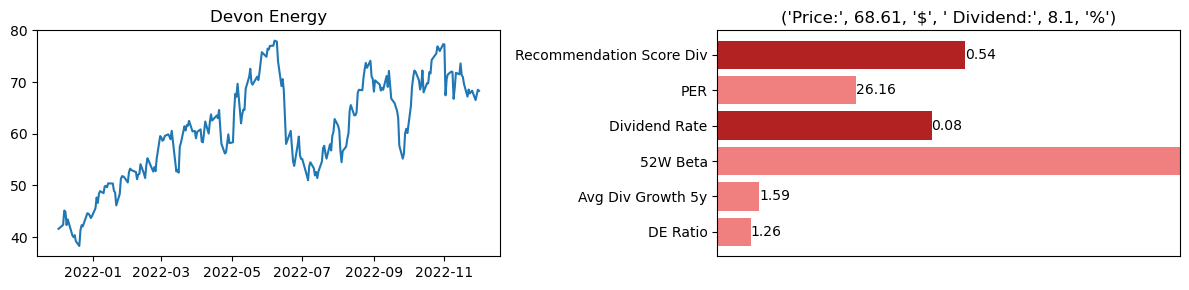

In [18]:
DivTop1 = DivRecom.sort_values('Dividend Rate', ascending = False).head(1).reset_index()

#scrape market data of the past year
top1div = DivTop1['Symbol'].to_list()
plotdata = yf.download(top1div, actions = False, period="1y")
plotdata.drop(columns=["Open", "High", "Low", "Adj Close", "Volume"], inplace=True)
plotdata.reset_index(inplace=True)

#generate df for plotting
parameterplot = DivTop1[['Symbol', 'Recommendation Score Div', 'PER', 'Dividend Rate', '52W Beta', 'Avg Div Growth 5y', 'DE Ratio']]
parameterplot['Recommendation Score Div'] = parameterplot['Recommendation Score Div']*1.75
parameterplot['PER'] = parameterplot['PER']/50
parameterplot['Dividend Rate'] = parameterplot['Dividend Rate']*10
parameterplot['Avg Div Growth 5y'] = parameterplot['Avg Div Growth 5y']/10
parameterplot['DE Ratio'] = parameterplot['DE Ratio']/10
parameterplot = parameterplot.transpose().reset_index().iloc[1: , :]

#build figure
fig=plt.figure()
fig.set_size_inches(12, 3)

ax=fig.add_subplot(121)
ax.set(title=DivTop1.at[0, 'Security'])
ax.plot(plotdata['Date'], plotdata['Close'])

ax=fig.add_subplot(122)
ax.set(title=("Price:", round(DivTop1.at[0, 'Closing Today'], 2), "$", " Dividend:", round(DivTop1.at[0, 'Dividend Rate']*100, 2), "%"))
hbars = ax.barh(parameterplot['index'], parameterplot[0], color=['firebrick','lightcoral','firebrick' ,'lightcoral' ,'lightcoral' ,'lightcoral'])
ax.tick_params(
    axis='x',         
    which='both',    
    bottom=False,    
    top=False,        
    labelbottom=False)
ax.bar_label(hbars, labels=[round(parameterplot.iat[0, 1]/1.75, 2), round(parameterplot.iat[1, 1]*50, 2), round(parameterplot.iat[2, 1]/10, 2), round(parameterplot.iat[3, 1], 2), 
                            round(parameterplot.iat[4, 1]*10, 2), round(parameterplot.iat[5, 1]*10, 2)])
ax.invert_yaxis()
plt.xlim([0, 1.75])

fig.tight_layout()
plt.show()

<h4>PER-King</h4>

[*********************100%***********************]  1 of 1 completed


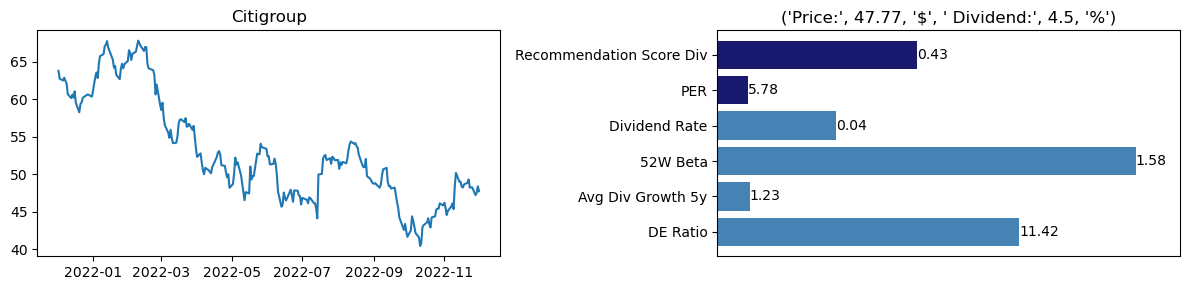

In [19]:
DivTop1 = DivRecom.sort_values('PER', ascending = True).head(1).reset_index()

#scrape market data of the past year
top1div = DivTop1['Symbol'].to_list()
plotdata = yf.download(top1div, actions = False, period="1y")
plotdata.drop(columns=["Open", "High", "Low", "Adj Close", "Volume"], inplace=True)
plotdata.reset_index(inplace=True)

#generate df for plotting
parameterplot = DivTop1[['Symbol', 'Recommendation Score Div', 'PER', 'Dividend Rate', '52W Beta', 'Avg Div Growth 5y', 'DE Ratio']]
parameterplot['Recommendation Score Div'] = parameterplot['Recommendation Score Div']*1.75
parameterplot['PER'] = parameterplot['PER']/50
parameterplot['Dividend Rate'] = parameterplot['Dividend Rate']*10
parameterplot['Avg Div Growth 5y'] = parameterplot['Avg Div Growth 5y']/10
parameterplot['DE Ratio'] = parameterplot['DE Ratio']/10
parameterplot = parameterplot.transpose().reset_index().iloc[1: , :]

#build figure
fig=plt.figure()
fig.set_size_inches(12, 3)

ax=fig.add_subplot(121)
ax.set(title=DivTop1.at[0, 'Security'])
ax.plot(plotdata['Date'], plotdata['Close'])

ax=fig.add_subplot(122)
ax.set(title=("Price:", round(DivTop1.at[0, 'Closing Today'], 2), "$", " Dividend:", round(DivTop1.at[0, 'Dividend Rate']*100, 2), "%"))
hbars = ax.barh(parameterplot['index'], parameterplot[0], color=['midnightblue','midnightblue','steelblue' ,'steelblue' ,'steelblue' ,'steelblue'])
ax.tick_params(
    axis='x',         
    which='both',    
    bottom=False,    
    top=False,        
    labelbottom=False)
ax.bar_label(hbars, labels=[round(parameterplot.iat[0, 1]/1.75, 2), round(parameterplot.iat[1, 1]*50, 2), round(parameterplot.iat[2, 1]/10, 2), round(parameterplot.iat[3, 1], 2), 
                            round(parameterplot.iat[4, 1]*10, 2), round(parameterplot.iat[5, 1]*10, 2)])
ax.invert_yaxis()
plt.xlim([0, 1.75])

fig.tight_layout()
plt.show()

<h3>Section 2.2: Growth stocks</h3>
<h4>Recommendation score champs</h4>

In [20]:
#generate df with top 3 recommendation scores
GrwRecomTop3 = GrwRecom.sort_values('Recommendation Score Growth', ascending = False).head(3).reset_index()

#scrape market data of the past year
top3Grw = GrwRecomTop3['Symbol'].to_list()
plotdata = yf.download(top3Grw, actions = False, period="1y")
plotdata.drop(columns=["Open", "High", "Low", "Adj Close", "Volume"], inplace=True)
plotdata = plotdata.droplevel(0, axis=1)
plotdata.reset_index(inplace=True)

#generate df for plotting
parameterplot = GrwRecomTop3[['Symbol', 'Recommendation Score Growth', 'PER', 'Dividend Rate', '52W Beta', 'Earnings Growth', 'DE Ratio']]
parameterplot['Recommendation Score Growth'] = parameterplot['Recommendation Score Growth']*1.75
parameterplot['PER'] = parameterplot['PER']/50
parameterplot['Dividend Rate'] = parameterplot['Dividend Rate']*10
parameterplot['Earnings Growth'] = parameterplot['Earnings Growth']/5
parameterplot['DE Ratio'] = parameterplot['DE Ratio']/10
parameterplot = parameterplot.transpose().reset_index().iloc[1: , :]

[*********************100%***********************]  3 of 3 completed


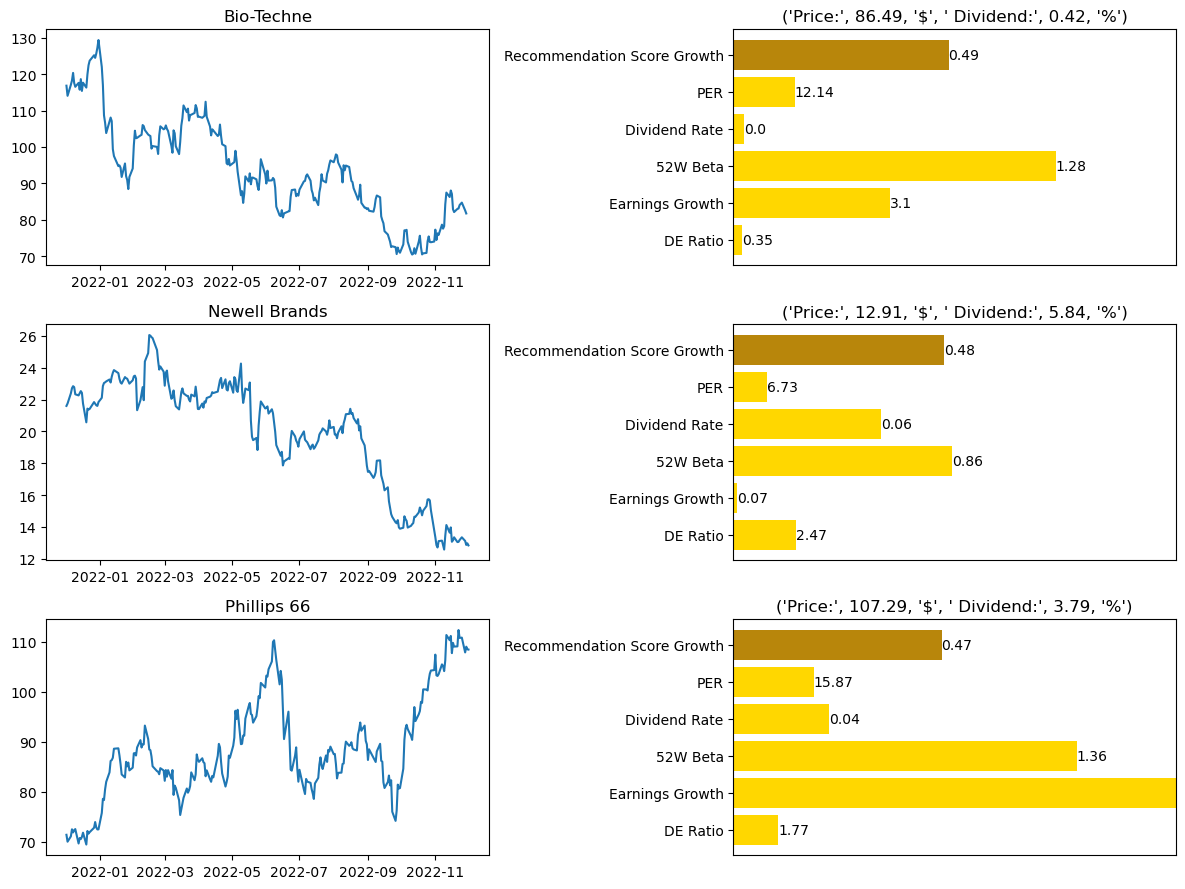

In [21]:
#build figure
fig=plt.figure()
fig.set_size_inches(12, 9)

ax=fig.add_subplot(321)
ax.set(title=GrwRecomTop3.at[0, 'Security'])
ax.plot(plotdata['Date'], plotdata[GrwRecomTop3.at[0, 'Symbol']])

ax=fig.add_subplot(322)
ax.set(title=("Price:", round(GrwRecomTop3.at[0, 'Closing Today'], 2), "$", " Dividend:", round(GrwRecomTop3.at[0, 'Dividend Rate']*100, 2), "%"))
hbars = ax.barh(parameterplot['index'], parameterplot[0], color=['darkgoldenrod','gold','gold' ,'gold' ,'gold' ,'gold'])
ax.tick_params(
    axis='x',         
    which='both',    
    bottom=False,    
    top=False,        
    labelbottom=False)
ax.bar_label(hbars, labels=[round(parameterplot.iat[0, 1]/1.75, 2), round(parameterplot.iat[1, 1]*50, 2), round(parameterplot.iat[2, 1]/10, 2), round(parameterplot.iat[3, 1], 2), 
                            round(parameterplot.iat[4, 1]*5, 2), round(parameterplot.iat[5, 1]*10, 2)])
ax.invert_yaxis()
plt.xlim([0, 1.75])

ax=fig.add_subplot(323)
ax.set(title=GrwRecomTop3.at[1, 'Security'])
ax.plot(plotdata['Date'], plotdata[GrwRecomTop3.at[1, 'Symbol']])

ax=fig.add_subplot(324)
ax.set(title=("Price:", round(GrwRecomTop3.at[1, 'Closing Today'], 2), "$", " Dividend:", round(GrwRecomTop3.at[1, 'Dividend Rate']*100, 2), "%"))
hbars = ax.barh(parameterplot['index'], parameterplot[1], color=['darkgoldenrod','gold','gold' ,'gold' ,'gold' ,'gold'])
ax.tick_params(
    axis='x',         
    which='both',    
    bottom=False,    
    top=False,        
    labelbottom=False)
ax.bar_label(hbars, labels=[round(parameterplot.iat[0, 2]/1.75,2), round(parameterplot.iat[1, 2]*50, 2), round(parameterplot.iat[2, 2]/10, 2), round(parameterplot.iat[3, 2], 2), 
                            round(parameterplot.iat[4, 2]*5, 2), round(parameterplot.iat[5, 2]*10, 2)])
plt.xlim([0, 1.75])
ax.invert_yaxis()

ax=fig.add_subplot(325)
ax.set(title=GrwRecomTop3.at[2, 'Security'])
ax.plot(plotdata['Date'], plotdata[GrwRecomTop3.at[2, 'Symbol']])

ax=fig.add_subplot(326)
ax.set(title=("Price:", round(GrwRecomTop3.at[2, 'Closing Today'], 2), "$", " Dividend:", round(GrwRecomTop3.at[2, 'Dividend Rate']*100, 2), "%"))
hbars = ax.barh(parameterplot['index'], parameterplot[2], color=['darkgoldenrod','gold','gold' ,'gold' ,'gold' ,'gold'])
ax.tick_params(
    axis='x',         
    which='both',    
    bottom=False,    
    top=False,        
    labelbottom=False)
ax.bar_label(hbars, labels=[round(parameterplot.iat[0, 3]/1.75,2), round(parameterplot.iat[1, 3]*50, 2), round(parameterplot.iat[2, 3]/10, 2), round(parameterplot.iat[3, 3], 2), 
                            round(parameterplot.iat[4, 3]*5, 2), round(parameterplot.iat[5, 3]*10, 2)])
plt.xlim([0, 1.75])
ax.invert_yaxis()

fig.tight_layout()
plt.show()

<h4>Earnings Growth King</h4>

[*********************100%***********************]  1 of 1 completed


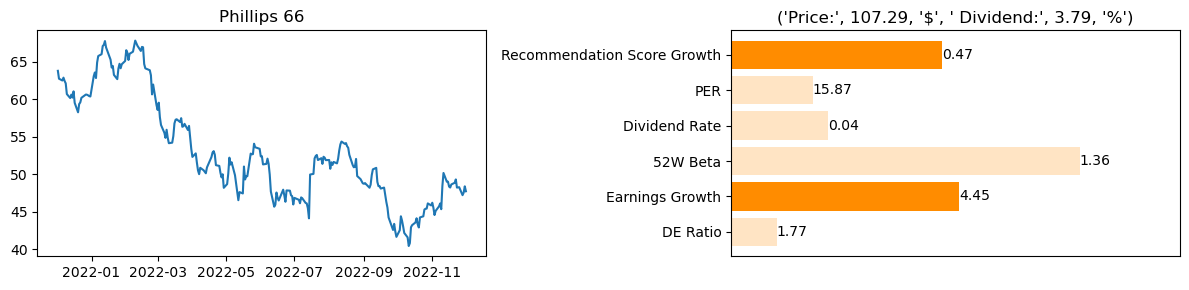

In [22]:
GrwTop1 = GrwRecom.sort_values('Earnings Growth', ascending = False).head(1).reset_index()

#scrape market data of the past year
top1Grw = GrwTop1['Symbol'].to_list()
plotdata = yf.download(top1div, actions = False, period="1y")
plotdata.drop(columns=["Open", "High", "Low", "Adj Close", "Volume"], inplace=True)
plotdata.reset_index(inplace=True)

#generate df for plotting
parameterplot = GrwTop1[['Symbol', 'Recommendation Score Growth', 'PER', 'Dividend Rate', '52W Beta', 'Earnings Growth', 'DE Ratio']]
parameterplot['Recommendation Score Growth'] = parameterplot['Recommendation Score Growth']*1.75
parameterplot['PER'] = parameterplot['PER']/50
parameterplot['Dividend Rate'] = parameterplot['Dividend Rate']*10
parameterplot['Earnings Growth'] = parameterplot['Earnings Growth']/10
parameterplot['DE Ratio'] = parameterplot['DE Ratio']/10
parameterplot = parameterplot.transpose().reset_index().iloc[1: , :]

#build figure
fig=plt.figure()
fig.set_size_inches(12, 3)

ax=fig.add_subplot(121)
ax.set(title=GrwTop1.at[0, 'Security'])
ax.plot(plotdata['Date'], plotdata['Close'])

ax=fig.add_subplot(122)
ax.set(title=("Price:", round(GrwTop1.at[0, 'Closing Today'], 2), "$", " Dividend:", round(GrwTop1.at[0, 'Dividend Rate']*100, 2), "%"))
hbars = ax.barh(parameterplot['index'], parameterplot[0], color=['darkorange','bisque','bisque' ,'bisque' ,'darkorange' ,'bisque'])
ax.tick_params(
    axis='x',         
    which='both',    
    bottom=False,    
    top=False,        
    labelbottom=False)
ax.bar_label(hbars, labels=[round(parameterplot.iat[0, 1]/1.75, 2), round(parameterplot.iat[1, 1]*50, 2), round(parameterplot.iat[2, 1]/10, 2), round(parameterplot.iat[3, 1], 2), 
                            round(parameterplot.iat[4, 1]*5, 2), round(parameterplot.iat[5, 1]*10, 2)])
ax.invert_yaxis()
plt.xlim([0, 1.75])

fig.tight_layout()
plt.show()

<h4>PER-King</h4>

[*********************100%***********************]  1 of 1 completed


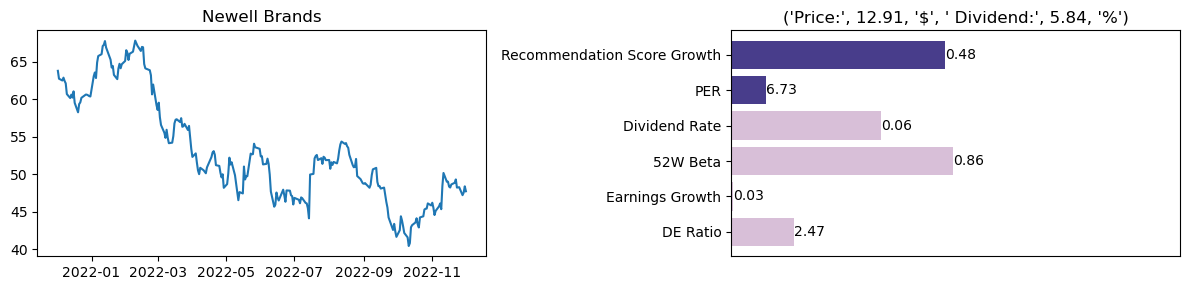

In [23]:
GrwTop1 = GrwRecom.sort_values('PER', ascending = True).head(1).reset_index()

#scrape market data of the past year
top1Grw = GrwTop1['Symbol'].to_list()
plotdata = yf.download(top1div, actions = False, period="1y")
plotdata.drop(columns=["Open", "High", "Low", "Adj Close", "Volume"], inplace=True)
plotdata.reset_index(inplace=True)

#generate df for plotting
parameterplot = GrwTop1[['Symbol', 'Recommendation Score Growth', 'PER', 'Dividend Rate', '52W Beta', 'Earnings Growth', 'DE Ratio']]
parameterplot['Recommendation Score Growth'] = parameterplot['Recommendation Score Growth']*1.75
parameterplot['PER'] = parameterplot['PER']/50
parameterplot['Dividend Rate'] = parameterplot['Dividend Rate']*10
parameterplot['Earnings Growth'] = parameterplot['Earnings Growth']/10
parameterplot['DE Ratio'] = parameterplot['DE Ratio']/10
parameterplot = parameterplot.transpose().reset_index().iloc[1: , :]

#build figure
fig=plt.figure()
fig.set_size_inches(12, 3)

ax=fig.add_subplot(121)
ax.set(title=GrwTop1.at[0, 'Security'])
ax.plot(plotdata['Date'], plotdata['Close'])

ax=fig.add_subplot(122)
ax.set(title=("Price:", round(GrwTop1.at[0, 'Closing Today'], 2), "$", " Dividend:", round(GrwTop1.at[0, 'Dividend Rate']*100, 2), "%"))
hbars = ax.barh(parameterplot['index'], parameterplot[0], color=['darkslateblue','darkslateblue','thistle' ,'thistle' ,'thistle' ,'thistle'])
ax.tick_params(
    axis='x',         
    which='both',    
    bottom=False,    
    top=False,        
    labelbottom=False)
ax.bar_label(hbars, labels=[round(parameterplot.iat[0, 1]/1.75, 2), round(parameterplot.iat[1, 1]*50, 2), round(parameterplot.iat[2, 1]/10, 2), round(parameterplot.iat[3, 1], 2), 
                            round(parameterplot.iat[4, 1]*5, 2), round(parameterplot.iat[5, 1]*10, 2)])
ax.invert_yaxis()
plt.xlim([0, 1.75])

fig.tight_layout()
plt.show()

In [24]:
checkpoint15 = np.datetime64('now')
print('Mission completed. Overall runtime was', checkpoint15 - checkpoint1, ".")

Mission completed. Overall runtime was 8775 seconds .
